Investigating the deviations of GLV from MiCRM, and quantifying it using error functions. 


In [1]:
# from github temp.jl, converted to python

# this section is about incorporating temperature dependence 


import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal

rng = default_rng(111) # random number generator 


# note that the u(T) and m(T) equation have the same structure, except the parameters are different. 
# both of the equations involve parameters like:
# B0 (base rate), E (activation energy), k (Boltzmann constant), Ed (deactivation energy), Tp (peak performance temperature), and Tr (reference temperature) 
# first, we want to generate random parameters for each consumer (as mentioned above), like B, E, Tp
# and for each of these temp-dependent parameters, we want to generate one for uptake u(T) and one for respiration m(T) 
# they're not actually fully random, as we do define mean and variance for teh parameters, and draw from a multivariate normal distribution 



def randtemp_param(N, kw):
    """
    Generate random temperature-dependent trait parameters for consumers.
    
    Returns:
        B: base rates (N x 2)
        E: activation energies (N x 2)
        Tp: peak temperatures (N x 2)
    """
    L = kw['L'] # leakage 
    rho_t = kw['rho_t']

    L_v = np.mean(L)
    B0_m = -1.4954 # I think this is mortality / respiration rate 
    B0_CUE = 0.1953 
    B0_u = np.log(np.exp(B0_m) / (1 - L_v - B0_CUE)) # I think this is uptake rate. dependent on carbon use efficiency (CUE) and leakage rate
    
    B0 = np.array([B0_u, B0_m]) # B0 is a vector of base rates for uptake and respiration
    B0_var = 0.17 * np.abs(B0) # variance of base rates, 0.17 is a scaling factor
    E_mean = np.array([0.8146, 0.5741]) # mean activation energies for uptake and respiration
    E_var = 0.1364 * E_mean # variance of activation energies, 0.1364 is a scaling factor
    cov_xy = rho_t * np.sqrt(B0_var * E_var) # covariance between base rates and activation energies, rho_t is the correlation coefficient

    cov_u = np.array([[B0_var[0], cov_xy[0]], [cov_xy[0], E_var[0]]]) # covariance matrix for uptake
    cov_m = np.array([[B0_var[1], cov_xy[1]], [cov_xy[1], E_var[1]]]) # covariance matrix for respiration

    allu = multivariate_normal.rvs(mean=[B0[0], E_mean[0]], cov=cov_u, size=N).T # draw random samples from multivariate normal distribution for uptake
    allm = multivariate_normal.rvs(mean=[B0[1], E_mean[1]], cov=cov_m, size=N).T # draw random samples from multivariate normal distribution for respiration

    B = np.column_stack((np.exp(allu[0]), np.exp(allm[0]))) # exponentiate the base rates to get the actual values
    E = np.column_stack((allu[1], allm[1])) # activation energies are already in the correct form

    Tpu = 273.15 + rng.normal(35, 5, N) # draw random peak temperatures for uptake from a normal distribution with mean 35 and std 5
    Tpm = Tpu + 3 # peak temperature for respiration is 3 degrees higher than for uptake
    Tp = np.column_stack((Tpu, Tpm)) # combine the peak temperatures into a single array 

    return B, E, Tp


# randtemp_param_test = randtemp_param(3, {'L': 0.4, 'rho_t': -0.75}) 
# print(randtemp_param_test) 
# this works - produces 2D arrays 


# now we have generated parameters (generating B, E, Tp) for each consumer 
# we did this by drawing from a multivariate normal distribution, with some constraints like mean, variance, correlation that we defined 
# now that the parameters are generated, we can incorporate them into the Arrhenius equation to calculate the temperature-dependent trait values 
# since uptake u(T) and respiration m(T) both depend on these parameters like B, E, Tp (which we have now defined) 




def temp_trait(N, kw):
    """
    Compute temperature-dependent trait scaling based on an Arrhenius-like thermal performance curve.
    
    Arguments:
        N: number of consumers
        kw: dict containing temperature parameters (T, Tr, Ed, L, rho_t)

    Returns:
        temp_p: temperature-scaled trait values (vector of size N)
        B, E: base rates and activation energies (N x 2)
        Tp: peak temperatures for uptake and respiration (N x 2)
    """
    k = 0.0000862  # Boltzmann constant. used in exponential term of the Arrhenius equation
    T = kw['T']
    Tr = kw['Tr'] 
    Ed = kw['Ed']

    B, E, Tp = randtemp_param(N, kw) # draw random base rates (B), activation energies (E), and peak temperatures (Tp) for each consumer. 
    # we are using the previously defined function to generate these parameters  

    # Arrhenius function with high-temp deactivation

    # uptake rate u(T)
    temp_p_u = B[:, 0] * np.exp((-E[:, 0] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 0] / (Ed - E[:, 0])) * np.exp(Ed / k * (1 / Tp[:, 0] - 1 / T)))
    
    # respiration rate m(T) 
    temp_p_m = B[:, 1] * np.exp((-E[:, 1] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 1] / (Ed - E[:, 1])) * np.exp(Ed / k * (1 / Tp[:, 1] - 1 / T)))

    temp_p = np.column_stack((temp_p_u, temp_p_m))  # shape (N,2)
    
    return temp_p, B, E, Tp


# temp_trait_test = temp_trait(3, {'T': 273.15 + 10, 'Tr': 273.15 + 10, 'Ed': 3.5, 'L': 0.4, 'rho_t': -0.75})
# print(temp_trait_test)


# this temp_trait function uses the previous randtemp_param function to generate parameters for TPC, which are B, E, Tp 
# and then it uses these parameters to calculate the temperature-dependent trait values (u and m, which are uptake and respiration)  
# it does this by putting these parameters into the Arrhenius-like TPC equations u(T) and m(T) 
# the inputs are N (number of consumers) and kw (a dictionary of parameters like T, Tr, Ed, L, rho_t)
# and the outputs are the temp_p (temperature-scaled trait values), B (base rates), E (activation energies), and Tp (peak temperatures)
# we could define some temperature T, and the temp_p functions would calculate the resulting u and m for that temperature 
# so using this, we can compare e.g. low vs high temperatures by defining different T values 
# and potentially make continuous graphs of temperature vs growth rate or something, and use that to inform timescale separation / GLV accuracy 




In [2]:
# from github micrm_params.jl, converted to python 

# in the previous block of code, we generated temperature-dependent parameters
# but those parameters were just for the TPC 
# we also need to produce the other parameters for MiCRM 
# so this block of code focuses on defining parameters for MiCRM 
# and we later use these parameters to run simulations etc 


# kw is a dictionary carrying all the model inputs and intermediate results (temp, TPC scaling, leakage scalar, etc) 
# we like to include it (like in def_m) even though it's not needed for the default version
# so that any generator function can just pull out what it needs from kw 

import numpy as np

# Default parameter-generating functions
def def_m(N, M, kw):
    # Respiration (mortality) rates: ones vector of length N.
    return np.ones(N)

def def_rho(N, M, kw):
    # Resource-specific supply rates: ones vector of length M.
    # this was originally resource loss rate, but i changed it to supply so it makes sense with the equation 
    return np.ones(M)

def def_omega(N, M, kw):
    # Resource loss rates: ones vector of length M.
    return np.ones(M)


# the above code for def_m and def_rho are just returning vectors of ones, length N for respiration (m) and length M for supply (rho). 
# these are like the 'default' respiration/mortality rates, and default resource supply rates. def = default 
# depends on number of consumers N and number of resources M 
# later we can add temperature dependence, using functions we defined in previous section of code 



def def_u(N, M, kw):
    # Uptake matrix: each of N rows is drawn from a symmetric Dirichlet of dimension M.
    # this establishes the structure of the uptake function - it's a matrix of N x M 
    # unlike others like respiration (m) which is just a vector of length N 
    # numpy.random.dirichlet uses concentration parameters of length M
    return np.random.dirichlet(alpha=np.ones(M), size=N)


# the 'u' is an N x M matrix. each of the rows are sampled from a Dirichlet distribution. 
# each consumer is a row, and each resource is a column. 
# each consumer's uptake across resources (sum of a row) is 1. but this is randomly allocated among M resources. 
# so i guess the uptake is not absolute units but it's relative to other resources? 
# also i think this describes uptake preference (so how much of a certain resource it uptakes vs another one, relatively), not uptake rate which can be temp-dependent (as previously defined) 


def def_l(N, M, L):
    # Leakage-transformation tensor: shape (N, M, M). For each consumer i and resource alpha,
    # draw an M-vector from Dirichlet and scale by L[i].
    l = np.zeros((N, M, M))
    phi = np.ones(M)
    for i in range(N):
        for alpha in range(M):
            draw = np.random.dirichlet(alpha=phi)
            l[i, alpha, :] = draw * L[i]
    return l

# again, i think leakage is relative units (arbitrary units or sth)
# more about the 'preference' in terms of which resources are leaked 


# this is the N x M x M leakage tensor. for each consumer i and resource index alpha, we are drawing an M-vector from a Dirichlet distribution, and scaling it by L[i].
# this is the leakage matrix for each consumer-resource pair. 
# from the paper: 
# L encodes each strain's metabolic network. L is the leakage-transformation tensor. L determines how consumed substrates are leaked / metabolically transformed 
# so i think for each strain N + each resource M, there is a whole vector (length M) of what resources that this one coudl be leaked as or transformed into. 

# these previous functions are 'default' functions for generating parameters
# they create simple placeholder values like vectors of 1s, or random Dirichlet distributions 
# these functions can be overridden (e.g. after we add temp dependence)

# next, in generate_params, we will add temperature dependence to the parameters 

def generate_params(N,
                     M,
                     f_m=def_m,
                     f_rho=def_rho,
                     f_omega=def_omega,
                     f_u=def_u,
                     f_l=def_l,
                     **kwargs):
    
    # f_m = def_m means that if we don't provide a function for f_m, it will use the default one (def_m)
    # this is why we had to define the default functions earlier 
    # **kwargs is any other keyword arguments (not directly specified as function inputs here, but bundled together in dictionary)
    
    """
    Generate temperature-dependent MiCRM parameters.

    Parameters:
        N, M       : integers, number of consumers and resources
        f_m, f_rho, f_omega, f_u, f_l : functions to generate m, rho, omega, u, l
        kwargs     : other keyword arguments (e.g., T, rho_t, Tr, Ed, L)

    Returns:
        params : dict with keys 'N', 'M', 'u', 'm', 'l', 'rho', 'omega', 'lambda',
                 plus temperature traits and any extra kwargs
    """

    # Copy kwargs for internal use
    kw = dict(kwargs)

    # Temperature-dependent traits, as defined in previous code block 
    tt, B, E, Tp = temp_trait(N, kw) # according to previously defined temp_trait function 
    # tt is the first output of the temp_trait function, which is temp_p

    
    kw['tt'] = tt
   
    # in this section above:
    # we plug in N and kw (kw is a dictionary of parameters), both of which are inputs to the overall generate_params function
    # and using a previously defined function temp_trait, we get parameters for temperature dependence
    # the parameters generated include temp_p_u and temp_p_m 
    # now that we've generated temp_p_u and temp_p_m, we want to store them into kw dictionary 

    # Generate consumer parameters
    m = f_m(N, M, kw) # Respiration (mortality) rates
    u = f_u(N, M, kw) # Uptake matrix

    # this section above:
    # f_m and f_u generate the final parameters for uptake and mortality 
    # we haven't defined a custom function for f_m or f_u, so it will use the default ones we defined earlier
    # so here, it's basically same as m = def_m(N, M, kw) and u = def_u(N, M, kw)


    # Leakage-transformation tensor
    L = kw.get('L')         # Expect L in kwargs
    l = f_l(N, M, L)      # Leakage-transformation 

    # Total leakage per consumer-resource pair
    lambda_ = np.sum(l, axis=2)  # shape (N, M)

    # Resource parameters
    rho = f_rho(N, M, kw) 
    omega = f_omega(N, M, kw)

    # Assemble base parameter dict
    params = {
        'N': N,
        'M': M,
        'u': u,
        'm': m,
        'l': l,
        'rho': rho,
        'omega': omega,
        'lambda': lambda_,
        'L': L,
        'B': B,
        'E': E,
        'Tp': Tp,
        'tt': tt
    }
    # Merge in any extra user-supplied kwargs
    params.update(kwargs) 

    return params # so it shows the base parameter dictionary we defined within this function 





# test generate_params just to show how it works:
# given N, M, and other parameters like temperature, it generates parameters for MiCRM 
# and there is an element of stochasticity, because the community assemblies are random 

# params = generate_params(
#     N=10,
#     M=5,
#     T=310,
#     Tr=275,
#     Ed=2,
#     L=np.random.uniform(0.1, 0.5, size=N),
#     rho_t=1
# )

# print (params)






In [3]:
# from github dx_v2.jl, converted to python


# now that we've generated parameters, we can write the actual MiCRM model 




import numpy as np

def growth_MiCRM(dx, x, p, t, i):
    """
    Per-consumer growth contribution for the MiCRM system.
    
    dx : array of length N+M (mutated in-place)
    x  : current state vector [consumers (N), resources (M)]
    p  : parameter dict with keys 'm', 'u', 'l', 'N', 'M'
    t  : time (unused here)
    i  : index of the consumer species to update
    """
    # maintenance loss
    dx[i] = -x[i] * p['m'][i]  
    # uptake and leakage contributions
    for alpha in range(p['M']):
        resource_idx = p['N'] + alpha # index of the resource in the state vector, since dx is an array of length N+M
        uptake = x[resource_idx] * x[i] * p['u'][i, alpha]
        dx[i] += uptake
        # subtract leaked fraction
        for beta in range(p['M']):
            dx[i] -= x[i] * x[resource_idx] * p['u'][i, alpha] * p['l'][i, alpha, beta]



def supply_MiCRM(dx, x, p, t, alpha):
    """
    Supply (inflow minus outflow) for resource pools.
    
    dx : array of length N+M (mutated in-place)
    x  : current state vector
    p  : parameter dict with keys 'rho', 'omega', 'N', 'M'
    t  : time (unused)
    alpha : index of the resource pool to update
    """
    idx = p['N'] + alpha
    dx[idx] = p['rho'][alpha] - x[idx] * p['omega'][alpha]

    # slightly confusing - previously omega was labelled supply and rho the decay 
    # but was probably a typo 
    # have fixed previous code and included omega again
    # where rho is supply, and omega is decay 




def depletion_MiCRM(dx, x, p, t, alpha, i):
    """
    Resource depletion (uptake and leakage reintroduction) for MiCRM.
    
    dx : array of length N+M (mutated in-place)
    x  : current state vector
    p  : parameter dict
    t  : time (unused)
    alpha : resource index
    i     : consumer index
    """
    idx = p['N'] + alpha
    # uptake depletes resource
    dx[idx] -= x[idx] * p['u'][i, alpha] * x[i] # x[i] is for consumers, and x[idx] is for resources
    # leaked material from other resources
    for beta in range(p['M']):
        leak_idx = p['N'] + beta
        dx[idx] += x[leak_idx] * x[i] * p['u'][i, beta] * p['l'][i, beta, alpha]



# the MiCRM_dx and MiCRM_dxx functions are 2 versions of the full MiCRM 
# MiCRM_dx delegates each 'piece' of dynamics to 3 helper functions that we previously defined 
# this function here just computes derivatives. no callback.

def MiCRM_dx(x, t, p,
             growth=growth_MiCRM,
             supply=supply_MiCRM,
             depletion=depletion_MiCRM):
    """
    Full derivative for MiCRM: consumer + resource dynamics.
    
    Returns a new dx array (length N+M).
    """
    dx = np.zeros_like(x)
    # consumer dynamics
    for i in range(p['N']):
        if x[i] > 1e-5: # anything smaller than this is seen as extinct 
            growth(dx, x, p, t, i)
    # resource dynamics
    for alpha in range(p['M']):
        supply(dx, x, p, t, alpha)
        for i in range(p['N']):
            if x[i] > 1e-5:
                depletion(dx, x, p, t, alpha, i)
    return dx


# below, the MiCRM_dxx function does not use helper functions defined outside of this function like growth_MiCRM
# here, all the consumer and resource updates are directly written in one place, not split into helper functions 
# extinctions are not ignored here, it actually computes every term
# no callback again (same as MiCRM_dx). as in, it keeps going, no condition to stop integrating 



def MiCRM_dxx(x, t, p):
    """
    Combined MiCRM ODE right-hand side without callbacks.
    """
    dx = np.zeros_like(x)
    # consumers
    for i in range(p['N']):
        dx[i] = -p['m'][i] * x[i]
        for alpha in range(p['M']):
            res_idx = p['N'] + alpha
            dx[i] += x[i] * x[res_idx] * p['u'][i, alpha]
            for beta in range(p['M']):
                dx[i] -= x[i] * x[res_idx] * p['u'][i, alpha] * p['l'][i, alpha, beta]
    # resources
    for alpha in range(p['M']):
        idx = p['N'] + alpha
        dx[idx] = p['rho'][alpha] - x[idx] * p['omega'][alpha]
        for i in range(p['N']):
            dx[idx] -= p['u'][i, alpha] * x[idx] * x[i]
            for beta in range(p['M']):
                leak_idx = p['N'] + beta
                dx[idx] += x[leak_idx] * x[i] * p['u'][i, beta] * p['l'][i, beta, alpha]
    return dx






In [4]:
# FIGURE OUT HOW THE DERIVATION WORKS! 
# i think here it just defines the terms like 'r' and 'aij' 
# but for the report, should understand better how the derivation works 

# from github EFF_LV_p_opt.jl, converted to python

# this section defines parameters for effective GLV 

# notes from original jl file:
# Function for calculating effective Lotka-Volterra parameters.
# It is necessary to supply the parameters p and an ODE problem 
# solution containing equilibrium values for the system in question.


import numpy as np

def eff_LV_params(p, sol, verbose=False):
    """
    Calculate effective Lotka‐Volterra parameters from a MiCRM equilibrium.
    
    Parameters
    ----------
    p : dict
        Parameter dict with keys:
          - 'M','N'        : ints, number of resources and consumers
          - 'l'            : leakage tensor, shape (N, M, M)
          - 'rho','omega'  : resource supply and loss vectors, length M
          - 'm'            : mortality vector, length N
          - 'u'            : uptake matrix, shape (N, M)
          - 'lambda'       : total leakage, shape (N, M)
    sol : 2D array, shape (N+M, T_steps)
        ODE solution; columns are timepoints, last column is equilibrium.
    verbose : bool, default False
        If True, also return the resource‐derivative matrix dR and the A matrix.
    
    Returns
    -------
    result : dict
        Always contains:
          - 'alpha' : effective species interaction matrix (N×N)
          - 'r'     : effective intrinsic growth rates (length N)
          - 'N'     : number of consumers
        If verbose:
          - 'dR'    : ∂R/∂C matrix (M×N)
          - 'A'     : resource‐interaction matrix (M×M)
    """
    # Unpack
    M, N = p['M'], p['N']
    l = p['l']          # shape (N, M, M)
    rho = p['rho']      # length M
    omega = p['omega']  # length M
    m = p['m']          # length N
    u = p['u']          # shape (N, M)
    lam = p['lambda']   # shape (N, M)
    
    # Kronecker delta
    delta = lambda x, y: 1 if x == y else 0

    # Equilibrium values (last column of sol)
    Ceq = sol.y[:N, -1]          # consumer abundances at eq. -1 means the last column (last timestep)
    Req = sol.y[N:, -1]          # resource abundances at eq. -1 means the last column (last timestep)
    
    # modified from sol to sol.y 
    
    
    # i don't think we've supplied what 'sol' is yet. 
    # when we call the function, we need to define some 'sol' 
    # and then pass that into the function (the function will find parameters for ELV) 
    # e.g. sol would be the result of some MiCRM equation, and then we pass that into this function, and it finds Ceq and Req from that sol 
    # and then uses Ceq and Req, along with other steps and derivations below, to find parameters for ELV 



    # 1) Build the resource‐interaction matrix A (shape M×M)
    #    A_{αβ} = -ω_α + sum_i [ l[i,α,β]*u[i,β]*Ceq[i]  –  u[i,β]*Ceq[i]*δ(α,β) ]
    A = np.zeros((M, M))
    for α in range(M):
        for β in range(M):
            s = -omega[α]
            for i in range(N):
                s += l[i, α, β] * u[i, β] * Ceq[i]
                if α == β:
                    s -= u[i, β] * Ceq[i]
            A[α, β] = s

    # 2) Precompute inverse of A and the term u*(1–λ)
    invA = np.linalg.inv(A)
    A_thing = u * (1.0 - lam)   # shape (N, M)

    # 3) Partial derivatives ∂R_α/∂C_j at equilibrium (shape M×N)
    dR = np.zeros((M, N))
    for α in range(M):
        for j in range(N):
            s = 0.0
            for β in range(M):
                for γ in range(M):
                    s += invA[α, β] * u[j, β] * Req[γ] * (delta(β, γ) - l[j, β, γ])
            dR[α, j] = s

    # 4) Effective species‐species interaction matrix α_ij (shape N×N)
    alpha = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            alpha[i, j] = np.sum(A_thing[i, :] * dR[:, j])

    # 5) Components for intrinsic growth rates
    O = np.zeros(N)
    for i in range(N):
        O[i] = np.sum(A_thing[i, :] * Req)

    P = np.zeros(N)
    for i in range(N):
        P[i] = np.dot(alpha[i, :], Ceq)

    # 6) Effective growth rates r_i = O_i – P_i – m_i
    r_eff = O - P - m

    # 7) Assemble results
    result = {'alpha': alpha, 'r': r_eff, 'N': N}
    if verbose:
        result.update({'dR': dR, 'A': A})
    return result




In [5]:
# from github LV_dx.jl, converted to python

# now that we have the parameters for the effective GLV (parameters from previous section of code) we can define the Lotka-Volterra equations

import numpy as np

def growth_LV(dx, x, p, t, i):
    """
    Compute the per-species contribution to the derivative dx[i] 
    for species i in a Lotka-Volterra system.
    Mutates the dx array in place.
    
    Arguments:
      dx : 1D array (length N) of derivatives to update
      x  : 1D array (length N) of current abundances
      p  : dict of parameters, with keys:
           - 'r': intrinsic growth rates (array of length N)
           - 'alpha': interaction matrix (N x N array)
           - 'N': number of species
      t  : current time (unused here, but included for API consistency)
      i  : index of the species to update
    """
    dx[i] += p['r'][i] * x[i]
    for j in range(p['N']):
        dx[i] += x[i] * p['alpha'][i, j] * x[j]


# growth_LV computes rate of change of a single species i in the Lotka-Volterra system
# it adds the intrinsic growth term (r_i * x_i) 
# and then for each other species j, it adds the interaction term (alpha_ij * x_j)
# this describes 1 species' contribution 



def LV_dx(x, t, p, growth=growth_LV):
    """
    Compute the full derivative vector for the Lotka-Volterra system.
    
    Arguments:
      x      : 1D array of current abundances
      t      : current time
      p      : dict of parameters (same as above)
      growth : function to compute per-species updates (defaults to growth_LV)
    
    Returns:
      dx : 1D array of derivatives for all species
    """
    dx = np.zeros_like(x)
    for i in range(p['N']):
        # only apply growth if population is above machine precision
        if x[i] > np.spacing(x[i]):
            growth(dx, x, p, t, i)
    return dx

# dx is the actual rate of change of the system, which is a vector of length N
# contains a whole system of LV differential equations, one for each species
# this LV_dx function loops through all species i, and calls growth_LV for each one
# the derivative vector dx can be passed to an ODE solver to compute the dynamics of the whole multi-species system over time 




# example usage:
# params = {
#     'N': 3,
#     'r': np.array([0.1, 0.2, 0.15]),
#     'alpha': np.array([[-0.01, -0.02, 0.0],
#                        [0.01, -0.03, -0.01],
#                        [0.0,  0.01, -0.02]])
# }
# x0 = np.array([1.0, 0.5, 0.2])
# t = 0.0
# dx = LV_dx(x0, t, params)
# print(dx)
# results would be [0.08   0.0965 0.0302] 


In [6]:
# FIGURE OUT. also read michael's github stuff on jacobian / linearisation etc 

# from github Jacobian.jl, converted to python

# this computes the Jacobian matrix 
# useful for downstream analysis on stability against perturbations 


import numpy as np

def eff_LV_jac(p_lv, sol, threshold=1e-7):
    """
    Compute the Jacobian matrix of the effective GLV system
    at equilibrium, restricted to the “feasible” subset of species.

    Parameters
    ----------
    p_lv : dict
        Output from eff_LV_params, with keys:
          - 'alpha': full N×N interaction matrix
          - 'r'    : length-N intrinsic growth rates
          - 'N'    : total number of species
    sol : OdeResult or similar
        Solution object from solve_ivp on the MiCRM ODEs.
        Expects sol.y shape = (N+M, n_timepoints)
    threshold : float
        Minimum equilibrium biomass to consider a species “present.”

    Returns
    -------
    LV_Jac : 2D array, shape (n_feasible, n_feasible)
        The Jacobian ∂(dx)/∂x of the reduced Lotka–Volterra
        system at equilibrium, only for species with biomass > threshold.
    """
    # 1) Extract final biomasses for consumers
    N_full = p_lv['N']
    # sol.y: rows 0..N_full-1 are consumer abundances
    bm = sol.y[:N_full, -1]

    # 2) Identify "feasible" species (biomass above threshold)
    feasible = np.where(bm > threshold)[0]
    n = feasible.size

    # 3) Subset the GLV parameters to those species
    alpha_full = p_lv['alpha']
    # Interaction submatrix
    alpha = alpha_full[np.ix_(feasible, feasible)]
    # Equilibrium biomasses for feasible species
    C = bm[feasible]

    # 4) Build the Jacobian: J_{ij} = α_{ij} * C_i
    #      (since d x_i/dt = x_i (r_i + Σ_j α_{ij} x_j))
    #      → ∂(dx_i)/∂x_j = δ_{i,j}(r_i + Σ_k α_{ik}C_k) + α_{ij} C_i
    # For off-diagonals and simpler local stability, one often uses α_{ij} C_i.
    LV_Jac = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            LV_Jac[i, j] = alpha[i, j] * C[i]

    return LV_Jac



In [ ]:
# from github sim_frame.jl, converted to python. sim_frame.jl includes the previous 6 files.
 

import numpy as np
from numpy.random import default_rng
from scipy.stats import dirichlet
from numpy.linalg import norm
import math


rng = default_rng()

# ————————————————————————————————————————————————
# Custom MiCRM‐parameter‐generator functions (override defaults)
# ————————————————————————————————————————————————

def F_m(N, M, kw):
    """
    Temperature‐dependent mortality (maintenance) rates.
    If 'tt' is in kw (an Nx2 array of TPC scalings), use the 2nd column;
    otherwise fallback to a constant 0.2 for each species.
    """
    if 'tt' in kw:
        # kw['tt'] assumed shape (N,2)
        return kw['tt'][:, 1] # this is the respiration/mortality part of 'tt', defined before. used to be temp_p_m.
    else:
        return np.full(N, 0.2)

def F_rho(N, M, kw):
    """
    Resource supply rates: constant ones by default.
    """
    return np.ones(M)

# could introduce temperature-dependence in this if we want to look at temp-dependent resource supply 
# same with omega below, seeing how temp affects loss/dilution of resources in specific ecosystems 

def F_omega(N, M, kw):
    """
    Resource loss/dilution rates: zero by default.
    """
    return np.zeros(M)

def F_u(N, M, kw):
    """
    Temperature‐scaled uptake matrix.
      - Draws N Dirichlet(1,…,1) rows of length M (relative preference).
      - Scales each row i by kw['tt'][i,0] if present, else by 2.5.
    """
    # draw relative preferences
    diri = np.stack([rng.dirichlet(np.ones(M)) for _ in range(N)], axis=0)
    
    if 'tt' in kw:
        u_sum = kw['tt'][:, 0] # this is the uptake part of 'tt', defined before. used to be temp_p_u. 
    else:
        u_sum = np.full(N, 2.5)
    
    # scale each row by its TPC magnitude
    return diri * u_sum[:, None]



"""

removed some irrelevant functions previously in code

- cosine similarity
- euclidean distance
- bray curtis dissimilarity (have modified and included this later on) 
- AIC - Akaike information criterion 

"""



In [62]:
# define functions for diversity 


##### Shannon diversity #####

def shannon (abundance): # abundance should be an array (incl values for all consumers in system) 
    C_shannon = np.asarray(abundance, dtype=float) # convert into numpy arrays of floats 
  
    ### normalise to convert abundance into something on a scale of 0-1 ###

    # total number of 'individuals' (add up all the relative abundances) 
    total_abundance = np.sum(C_shannon) # add up all the elements in this C_shannon array. total_abundance also a single value. 

    pi = C_shannon / total_abundance # pi is  an array. it now converts C_shannon into relative proportions, by dividing each element of C_shannon by the total_abundance value. 

    pi_lnpi = pi[pi > 0] * np.log(pi[pi > 0]) # this is pi * ln(pi). pi_lnpi should also be an array with N elements. 
    # keep only the pi > 0 ones. if pi = 0, will have issues with log. if pi = 0 it won't contribute to Shannon index anyway. 

    H = -np.sum(pi_lnpi) 

    return H 

# note: for Shannon diversity, might need to consider the case where total abundance is 0 (so would be dividing by 0)

# can compare Shannon diversity for 2 samples (GLV vs MiCRM for each temperature)

##### Bray-Curtis dissimilarity ##### 

# defined earlier already, but re-write anyway 


def bray_curtis_dissimilarity(G, M): # G = GLV, M = MiCRM 

    G_array = np.asarray(G, dtype=float) # convert G (abundance of each species predicted by GLV) into array 
    M_array = np.asarray(M, dtype=float) # convert M (abundance of each species predicted by MiCRM) into array 

    G_safe = np.where(G_array < 0, 0, G_array) # if any element (species) of the GLV-predicted array of abundances is less than 0, consider that 0
    M_safe = np.where(M_array < 0, 0, M_array) 

    GM_dissimilarity = np.sum(np.abs(G_safe - M_safe)) / np.sum(G_safe + M_safe) # bray-curtis dissimilarity between GLV and MiCRM predictions 

    return GM_dissimilarity 

# also consider the case where total abundance is 0 (so would be dividing by 0) 


### Jaccard ###

def jaccard_index(G, M, thresh=1e-8):
    """
    Jaccard index J = |A ∩ B| / |A ∪ B| for presence/absence sets.
    Presence := abundance > thresh.
    Returns 1.0 if both sets are empty.
    """
    G = np.asarray(G, dtype=float)
    M = np.asarray(M, dtype=float)
    if G.shape != M.shape:
        raise ValueError("G and M must have same shape")
    G_surv = G > thresh
    M_surv = M > thresh
    inter = np.logical_and(G_surv, M_surv).sum()
    union = np.logical_or(G_surv, M_surv).sum()
    return 1.0 if union == 0 else inter / union





In [70]:
### define functions for abundance deviation + species overlap between MiCRM and EGLV ###

"""
this is for each community simulation (N consumers), for each temperature
to be incorporated into the later functions and loops (loop this function for each temp, then for each community simulation)
"""

import numpy as np
from numpy.linalg import norm


def err_eq_and_overlap(C_LV_eq, C_MiCRM_eq, thresh=1e-6):
    """
    Compute:
    - Mean log-ratio error in predicted abundances (GLV vs MiCRM) 
    - Number of overlapping survivors (identity-based overlap)

    Only includes species that are predicted to survive by *both* models.

    Inputs:
    - C_LV_eq: GLV-predicted equilibrium consumer abundances (array-like)
    - C_MiCRM_eq: MiCRM-predicted equilibrium consumer abundances (array-like)
    - thresh: threshold below which species are considered extinct
    - eps: small pseudocount to avoid log(0)

    Returns:
    - equilibrium_error: mean log-ratio error between GLV and MiCRM (NaN if no shared survivors)
    - overlap_count: number of species predicted to survive by both models
    """

    # Convert to float arrays
    C_LV = np.asarray(C_LV_eq, dtype=float)
    C_Mi = np.asarray(C_MiCRM_eq, dtype=float)

    # Identify survivors (boolean masks)
    G_surv = C_LV > thresh
    M_surv = C_Mi > thresh

    # Overlap mask: species that survive in BOTH models
    overlap_mask = G_surv & M_surv # element-wise check, so overlap_mask is true only if BOTH G_surv and M_surv are true for a species 
    overlap_count = np.sum(overlap_mask) # counts how many TRUE entries there are (size of intersection for survivors) 

    if overlap_count == 0:
        return np.nan, 0  # No shared survivors, can't compute meaningful abundance deviation


    # Log ratio of overlapping species
    log_ratios = np.log(C_LV[overlap_mask] / C_Mi[overlap_mask])
    equilibrium_error = np.mean(log_ratios)

    return equilibrium_error, overlap_count


# define function to produce the Err(t) function showing deviations over time



import numpy as np

def err_time_series(
    times,       # 1D array of time‐points (shape (T,)), e.g. [0, 5, 10, …, 5000]
    C_LV_traj,   # 2D array of GLV abundances, shape (N, T)
    C_Mi_traj,   # 2D array of MiCRM abundances, shape (N, T)
    thresh=1e-6  # below this abundance we call a species “extinct”
    ):
    """
    For each time point t_j, compute:
      - Err(t_j) = mean_i log( C_LV[i,j] / C_Mi[i,j] ) over species surviving in BOTH models
      - overlap_counts[j] = how many species survive in both at t_j
    Returns two arrays, each of length T.

    note: 'j' is a loop index (for time), running from j = 0 to j = T-1 (last timepoint) 

    """

    # Unpack dimensions from the trajectories
    N, T = C_LV_traj.shape  
    #   N = number of species
    #   T = number of timepoints 

    # Pre‐allocate output arrays
    err_t          = np.empty(T, dtype=float)   # will hold Err(t_j) for j=0…T-1
    overlap_counts = np.empty(T, dtype=int)     # will hold overlap_counts[j]

    # Loop over each time‐index j
    for j in range(T):
        # j is the integer index of the time‐point (0 ≤ j < T)
        # time = times[j]  # could use this if you wanted to stamp the time, but we only need j

        # Extract the N‐vector of abundances at time‐point j
        C_LV_j = C_LV_traj[:, j]   # shape (N,)
        C_Mi_j = C_Mi_traj[:, j]   # shape (N,)

        # Boolean masks for who is “alive” in each model at t_j
        G_surv = C_LV_j > thresh   # True for species with LV‐abundance > thresh
        M_surv = C_Mi_j > thresh   # True for species with MiCRM‐abundance > thresh

        # Only keep those that survive in *both*
        mask = G_surv & M_surv      # element‐wise AND, shape (N,)
        overlap_counts[j] = mask.sum()  # count how many True’s

        if overlap_counts[j] == 0:
            # No species overlap → no meaningful log‐ratio
            err_t[j] = np.nan
        else:
            # Compute log‐ratios only on the overlapping survivors
            log_ratios = np.log(C_LV_j[mask] / C_Mi_j[mask])
            err_t[j]   = np.mean(log_ratios)

    return err_t, overlap_counts



# define function to produce the Errtraj, which integrates Err(t) and finds area under curve. represents trajectory deviation. 

def integrate_err(
    times,  # 1D array of time‐points, shape (T,)
    err_t   # 1D array of instantaneous errors, shape (T,)
    ):
    """
    Compute the time‐averaged trajectory error
      Err_traj = (1/(t_end - t_start)) * ∫ Err(t) dt
    using the trapezoid rule on the discrete grid.
    Returns a single float.
    """

    # Mask out any NaNs (where overlap = 0)
    valid     = ~np.isnan(err_t)
    t_valid   = times[valid]   # times where err_t is real
    err_valid = err_t[valid]   # corresponding error values

    # Need at least 2 points to do any integration
    if valid.sum() < 2:
        return np.nan

    # Numerically integrate Err(t) dt by the trapezoid rule:
    integral = np.trapz(err_valid, x=t_valid)

    # Divide by total time to get *average* error
    duration = t_valid[-1] - t_valid[0]  # here, t_valid[-1] == t_end
    return integral / duration


# when finding trajectory error, we only want to find it up to teq (time where both systems reach equilibrium) 
# hence we define this function below to work out the equilibrium states 


def estimate_teq(
    times,    # 1D array of sampled times, shape (T,)
    sol,      # MiCRM solution object from solve_ivp
    sol_lv,   # GLV   solution object from solve_ivp
    pT,       # parameter dict used for MiCRM_dxx
    p_lv,     # parameter dict used for LV_dx
    tol=1e-6, # threshold on derivative‐norm to call “flat”
    window=5  # require this many consecutive below‐tol points
    ):
    """
    Estimate the index j_eq corresponding to the time t_eq when BOTH
    MiCRM and GLV trajectories have effectively reached steady‐state.
    We do this by looking at the derivative norms ||dx/dt|| of each
    system at each sampled time, taking their maximum, and finding the
    first run of `window` consecutive samples all below `tol`.

    Returns
    -------
    j_eq : int
      Index into `times` such that times[j_eq] is our estimated t_eq.
      If no such run is found, returns T-1 (i.e., the last time index).
    """

    T = times.size
    # Prepare an array to store [||dx_mi||, ||dx_lv||] at each time
    deriv_norms = np.empty((T, 2), dtype=float)

    # Derive species count of consumers from sol_lv
    N_lv = sol_lv.y.shape[0]

    # Loop over each sampled time index
    for j, t in enumerate(times):
        # 1) MiCRM derivative at this time:
        x_mi       = sol.y[:, j]                      # state vector length N+M
        dx_mi      = MiCRM_dxx(x_mi, t, pT)            # compute RHS
        deriv_norms[j, 0] = norm(dx_mi)                # Euclidean norm
        
        # 2)  GLV derivative at this time:
        x_lv       = sol_lv.y[:, j]                   # state vector length N
        dx_lv      = LV_dx(x_lv, t, p_lv)             # compute RHS
        deriv_norms[j, 1] = norm(dx_lv)               # Euclidean norm

    # At each time j, take the worst‐case (largest) of the two norms
    combined_norm = np.max(deriv_norms, axis=1)       # shape (T,)

    # Now find the first index j where combined_norm[j:(j+window)]
    # are all < tol, i.e. both models stay flat for `window` steps
    for j in range(0, T - window + 1):
        # Check the next `window` points
        if np.all(combined_norm[j : j + window] < tol):
            # Once found, return j as the equilibrium index
            return j

    # If we never see `window` consecutive small‐derivative points, 
    # we assume equilibrium is at the final time
    return T - 1





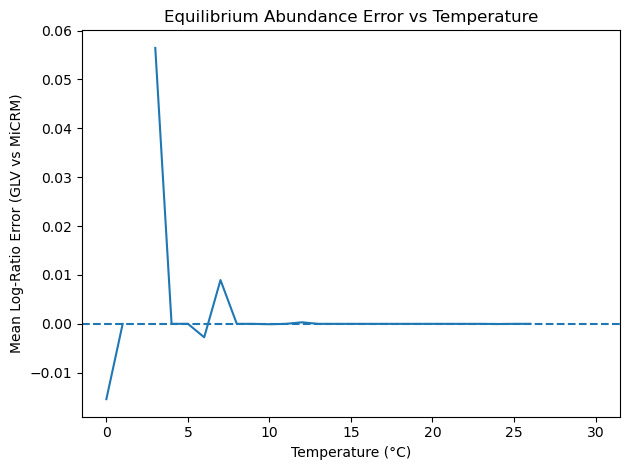

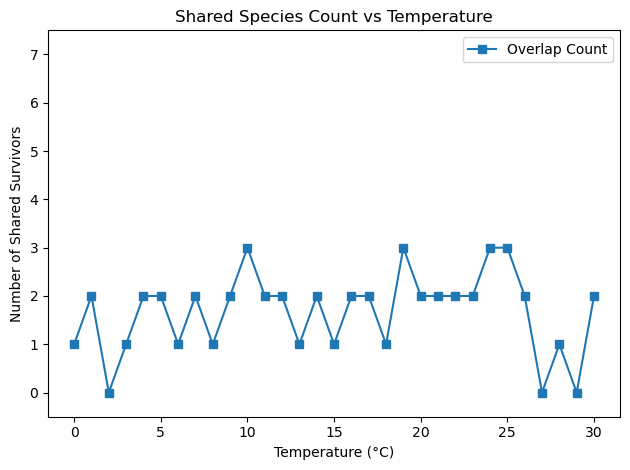

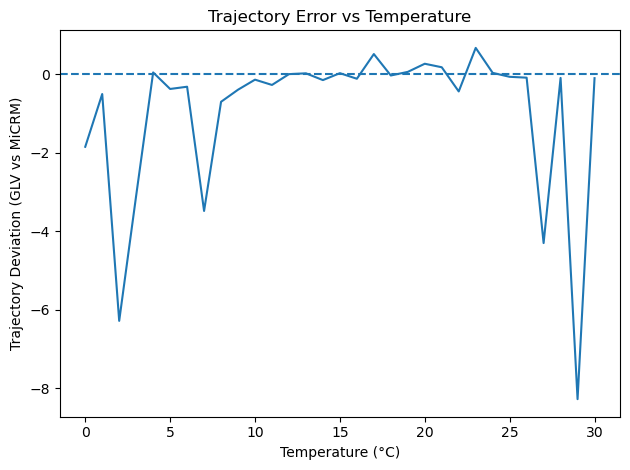

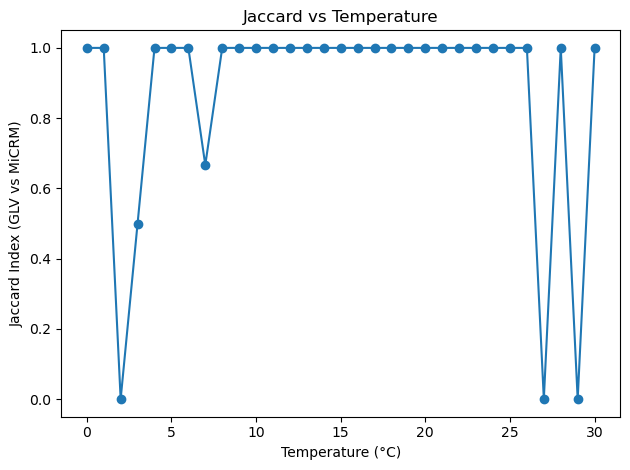

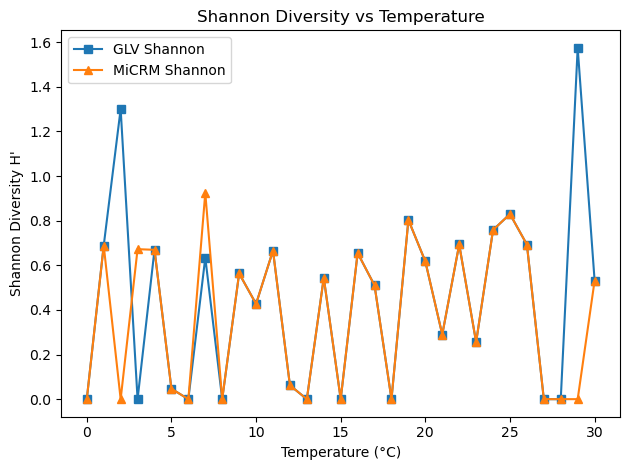

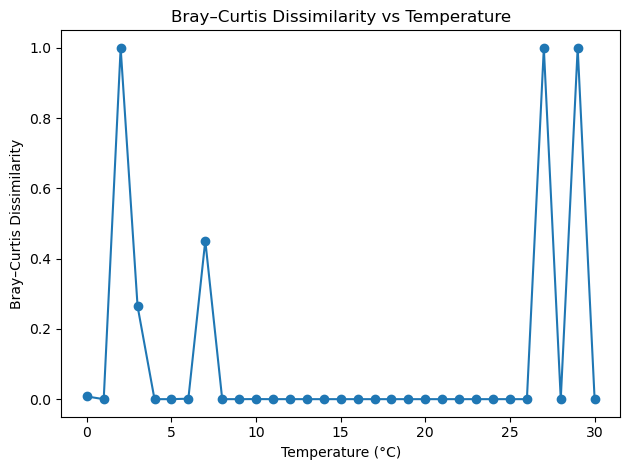

In [72]:
############################# PRODUCING ACTUAL SIMULATION GRAPHS #############################

import numpy as np
from numpy.random import default_rng
from scipy.integrate import solve_ivp
from numpy import linspace 
import matplotlib.pyplot as plt
from numpy.linalg import norm, eig

"""
want to first generate parameters for a particular randomly-assembled community
and then simulate 31 different temperatures for this same community (both MiCRM and EGLV graphs for each temperature) 
compare how temperature affects the deviation between MiCRM and EGLV graphs
"""


rng = default_rng(111)

N = 7
M = 5
L = np.full(N, 0.3) # leakage (this is not temp dependent, as per original MiCRM)

x0 = np.concatenate([np.full(N, 0.1), np.full(M, 1)]) # initial conditions for consumers and resources

# Temperature‐dependence parameters
num_temps = 31 # number of temperatures
rho_t = np.array([0.0, 0.0])   # minimal trade‐off
Tr = 273.15 + 10 # reference temperature (10 °C)
Ed = 3.5 



####### TEST OUT DIFFERENT TEMPERATURES #######


structural = generate_params(
    N, M,
    f_u=def_u,      # relative preferences only
    f_m=def_m,      # placeholder
    f_rho=def_rho,
    f_omega=def_omega,
    f_l=def_l,
    # *no* T, Tr, Ed, rho_t here
    L=L,
    T=273.15,   # dummy (This satisfies temp_trait’s requirement that kw contain T, rho_t, Tr, Ed) 
    # since we are using the default def_u and def_m here, they ignore kw, so any T will work 
    # this whole thing will just provide relative preferences (u) and a constant m=1    
    rho_t=rho_t,  # dummy
    Tr=Tr,        # dummy
    Ed=Ed         # dummy
)

# the 'structural' parameters are static and don't change with temperature
# e.g. the def_u only generates relative preferences, not absolute ones
# however the uptake rate (u) will change with temperature. the relative preferences won't. 
# other things like rho and omega also don't change with temperature



temp_vals = linspace(273.15, 273.15 + 30, num_temps) # 31 temperatures from 0 to 30 degrees C

results = [] # store results for each temperature. it is a list of dictionaries. each temp would produce its own dictionary. 

for T in temp_vals:

    # temp-dependent scalars

    temp_p, B, E, Tp = temp_trait(N, {
        'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L
    })
    temp_p_u = temp_p[:,0]
    temp_p_m = temp_p[:,1]

    # full parameter dictionary for this temp

    pT = {
        **structural,            # brings in u_pref, l, B, E, Tp, L, N, M, etc.
        'u': structural['u'] * temp_p_u[:,None],  # absolute uptake rates. the preference matrix from structural['u'] is multiplied (scaled) by the temperature-dependent uptake rates
        'm': temp_p_m,                            # mortality rates. the preference matrix from structural['m'] is multiplied (scaled) by the temperature-dependent mortality rates
        'lambda': np.sum(structural['l'], axis=2),
        'T': T
    }   
    

    # set up integration range

    t_max_micrm = 5000
    t_max_glv   = 5000

    t_eval_micrm = np.linspace(0, t_max_micrm, 1000)
    t_eval_glv   = np.linspace(0, t_max_glv,   1000)


    # solve MiCRM at this temperature
    

    sol = solve_ivp(
        lambda t, y: MiCRM_dxx(y, t, pT),
        t_span=(0, t_max_micrm),
        y0=x0,
        method='BDF',
        t_eval=t_eval_micrm 
    )

    
    # solve EGLV at this temperature
    
    p_lv = eff_LV_params(pT, sol, verbose=False)

    sol_lv = solve_ivp(
        lambda t, y: LV_dx(y, t, p_lv),
        t_span=(0, t_max_glv), 
        y0=sol.y[:N, 0],
        method='BDF', 
        t_eval=t_eval_glv        
        )
    
    ##### deviation calculations #####

    # first collect the equilibrium values for MiCRM and GLV (this is the last value in time series, t1)
    C_MiCRM_eq = sol.y[:N, -1] # equilibrium consumer biomass
    C_LV_eq = sol_lv.y[:N, -1] # equilibrium consumer biomass

       
    # equilibrium abundance deviation 
    ErrEqAb, overlap = err_eq_and_overlap(C_LV_eq, C_MiCRM_eq)

    # trajectory deviation  
    times      = sol.t                   # shape (T,). this defines the time array to be investigated in trajectory deviations 
    C_Mi_traj  = sol.y[:N, :]            # shape (N, T). this is the MiCRM trajectory, to be analysed in trajectory deviations 
    C_LV_traj  = sol_lv.y[:N, :]         # shape (N, T). this is the GLVM trajectory, to be analysed in trajectory deviations 
    err_t, overlap_t = err_time_series(times, C_LV_traj, C_Mi_traj) # first get the time series 
    j_eq = estimate_teq(times, sol, sol_lv, pT, p_lv, tol=1e-6, window=5) # find equilibrium time 
    times_crop = times[: j_eq + 1] # crop time array to equilibrium 
    err_crop   = err_t[: j_eq + 1] # crop trajectory error array to equilibrium 
    Err_traj = integrate_err(times_crop, err_crop) # integrate over [0, t_eq] instead of [0, t_max]

    # diversity deviation
    jaccard = jaccard_index(C_LV_eq, C_MiCRM_eq, thresh=1e-6)
    sh_LV = shannon(C_LV_eq)
    sh_Mi = shannon(C_MiCRM_eq)
    bc = bray_curtis_dissimilarity(C_LV_eq, C_MiCRM_eq)
    
    ##### store results as a dictionary ##### 

    results.append(dict(T=T, 
                        sol=sol, 
                        sol_lv=sol_lv, 
                        ErrEqAb=ErrEqAb, 
                        overlap=overlap,
                        ErrTraj=Err_traj,
                        jaccard=jaccard,
                        sh_LV=sh_LV,
                        sh_Mi=sh_Mi,
                        bray_curtis=bc
                        ))

# analyse results for equilibrium abundance

# extract values for plotting 
temps_C = temp_vals - 273.15 # Convert temperature array from K to °C
errs     = [r['ErrEqAb'] for r in results]
overlaps = [r['overlap']  for r in results]
errtraj = [r['ErrTraj']  for r in results]
jaccards = [r['jaccard'] for r in results]
sh_lvs   = [r['sh_LV']   for r in results]
sh_mis   = [r['sh_Mi']   for r in results]
bcs = [r['bray_curtis']   for r in results]



######################################### PLOTTING #############################################


import matplotlib.pyplot as plt

# plot abundance deviation at equilibrium 
plt.figure()
plt.plot(temps_C, errs)
plt.xlabel("Temperature (°C)")
plt.ylabel("Mean Log-Ratio Error (GLV vs MiCRM)")
plt.title("Equilibrium Abundance Error vs Temperature")
plt.axhline(0, linestyle='--')   # horizontal zero line
plt.tight_layout()
plt.show()

# plot number of species overlap for GLV/MiCRM at equilibrium (accuracy in terms of diversity predictions)
plt.figure()
plt.plot(temps_C, overlaps, marker='s', label='Overlap Count')
plt.xlabel("Temperature (°C)")
plt.ylabel("Number of Shared Survivors")
plt.title("Shared Species Count vs Temperature")
plt.ylim(-0.5, N + 0.5)  # N is total species, e.g. 7
plt.legend()
plt.tight_layout()
plt.show()

# plot trajectory deviation 
plt.figure()
plt.plot(temps_C, errtraj)
plt.xlabel("Temperature (°C)")
plt.ylabel("Trajectory Deviation (GLV vs MiCRM)")
plt.title("Trajectory Error vs Temperature")
plt.axhline(0, linestyle='--')   # horizontal zero line
plt.tight_layout()
plt.show()

# Temperature vs Jaccard
plt.figure()
plt.plot(temps_C, jaccards, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Jaccard Index (GLV vs MiCRM)")
plt.title("Jaccard vs Temperature")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# Temperature vs Shannon diversity (two lines)
plt.figure()
plt.plot(temps_C, sh_lvs, marker='s', label="GLV Shannon")
plt.plot(temps_C, sh_mis, marker='^', label="MiCRM Shannon")
plt.xlabel("Temperature (°C)")
plt.ylabel("Shannon Diversity H'")
plt.title("Shannon Diversity vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

# Bray-Curtis (for community composition - incorporating both diversity + abundance)

plt.figure()
plt.plot(temps_C, bcs, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bray–Curtis Dissimilarity")
plt.title("Bray–Curtis Dissimilarity vs Temperature")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

